**Exploring Movie Quote Analysis**

"You had me at hello", "We'll always have Paris", "May the Force be with you". The most memorable movie quotes are always concise and powerful. However, are those the only factors that go into a memorable quote? Do we love certain quotes because their inherent lexical beauty or just because Clint Eastwood always sounds really cool. In short, is there any bias in the quotes that we find most memorable?
We will be exploring this idea in this document. Our research questions are:

- What is the gender and age distribution of actors who deliver memorable quotes?
- How does the sentiment of memorable quotes evolve over time? How are these trends affected by conditioning on the actor’s age and gender?
- Are there particular themes among the memorable quotes, related to demographic factors?


First we import our cleaned data

In [8]:
import pandas as pd
df = pd.read_csv("df_cleaned-4.csv")
df

,Unnamed: 0,movie_title,character,memorable_quote,actor,actor_id,actor_bio,actor_DOB,gender,release_date,age_at_release,approx_age_filming,quote_count
0,0,10 things i hate about you,bianca,You're asking me out? That's so cute! What's y...,Larisa Oleynik,nm0646351,"Larisa Oleynik was born in Santa Clara County,...",1981-06-07,F,1999-03-31,18.0,17.0,1
1,1,10 things i hate about you,cameron,"Just 'cause you're beautiful, that doesn't mea...",Joseph Gordon-Levitt,nm0330687,"Joseph Gordon-Levitt is an actor, filmmaker, a...",1981-02-17,M,1999-03-31,18.0,17.0,3
2,2,10 things i hate about you,joey,Watching that bitch violate my car doesn't cou...,Andrew Keegan,nm0005080,"Andrew Keegan was born in Shadow Hills, Califo...",1979-01-29,M,1999-03-31,20.0,19.0,1
3,3,10 things i hate about you,kat,"I guess in this society, being male and an ass...",Julia Stiles,nm0005466,"Lovely, Julia (O'Hara) Stiles, of Irish, Engli...",1981-03-28,F,1999-03-31,18.0,17.0,4
4,4,10 things i hate about you,michael,"I have a dick on my face, don't I?",David Krumholtz,nm0472710,David Krumholtz is an American actor and comed...,1978-05-15,M,1999-03-31,21.0,20.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,1859,you've got mail,kevin,I always take a relationship to the next level...,Dave Chappelle,nm0152638,Dave Chappelle's career started while he was i...,1973-08-24,M,1998-12-18,25.0,24.0,1
1860,1860,young frankenstein,igor,"Two nasty lookin' switches over there, but I'm...",Marty Feldman,nm0001204,"""I am too old to die young, and too young to g...",1934-07-08,M,1974-12-15,40.0,39.0,1
1861,1861,zerophilia,sydney,That's the thing about the truth. It'll set yo...,Gina Bellman,nm0069109,Gina Bellman was born on 10 July 1966 in Auckl...,1966-07-10,F,2006-10-13,40.0,39.0,1
1862,1862,zulu dawn,crealock,"Excuse me, my Lord, there's something I must c...",Michael Jayston,nm0419785,Michael was born in Nottingham where he was ed...,1935-10-29,M,1979-12-14,44.0,43.0,1


In [9]:
#divide into individual quotes
df_exploded = df.assign(memorable_quote=df['memorable_quote'].str.split('_')).explode('memorable_quote')

**Sentiment Analysis with NLTK**

We will use sentiment analysis to see if there is a bias based on in the quotes that are deemed memorable. For instance, are quotes more likely to be memorable if they are depressing and said by 60+ year old men?

First we need to install Python's NLTK library

In [10]:
pip install nltk

In [11]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

We first preprocess the text by turning all letters lower case and then removing stopwords like "is" or "the". Then we use the lemmatizer to break down any words to their basic meaning (ie. cars --> car). Then we put the deconstructed words back into a string then apply the string to a new column in the dataframe.

In [13]:
def preprocess_text(text):
  tokens = word_tokenize(text.lower())
  stop_words = set(stopwords.words("english"))
  filtered_tokens = [token for token in tokens if token not in stop_words]
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
  processed_text = " ".join(lemmatized_tokens)
  return processed_text

df_exploded["reviewText"] = df_exploded["memorable_quote"].apply(preprocess_text)
df_exploded

,Unnamed: 0,movie_title,character,memorable_quote,actor,actor_id,actor_bio,actor_DOB,gender,release_date,age_at_release,approx_age_filming,quote_count,reviewText
0,0,10 things i hate about you,bianca,You're asking me out? That's so cute! What's y...,Larisa Oleynik,nm0646351,"Larisa Oleynik was born in Santa Clara County,...",1981-06-07,F,1999-03-31,18.0,17.0,1,'re asking ? 's cute ! 's name ?
1,1,10 things i hate about you,cameron,"Just 'cause you're beautiful, that doesn't mea...",Joseph Gordon-Levitt,nm0330687,"Joseph Gordon-Levitt is an actor, filmmaker, a...",1981-02-17,M,1999-03-31,18.0,17.0,3,"'cause 're beautiful , n't mean treat people l..."
1,1,10 things i hate about you,cameron,And I'm BACK IN THE GAME!,Joseph Gordon-Levitt,nm0330687,"Joseph Gordon-Levitt is an actor, filmmaker, a...",1981-02-17,M,1999-03-31,18.0,17.0,3,'m back game !
1,1,10 things i hate about you,cameron,You embarrassed the girl. Sacrifice yourself o...,Joseph Gordon-Levitt,nm0330687,"Joseph Gordon-Levitt is an actor, filmmaker, a...",1981-02-17,M,1999-03-31,18.0,17.0,3,embarrassed girl . sacrifice alter dignity eve...
2,2,10 things i hate about you,joey,Watching that bitch violate my car doesn't cou...,Andrew Keegan,nm0005080,"Andrew Keegan was born in Shadow Hills, Califo...",1979-01-29,M,1999-03-31,20.0,19.0,1,watching bitch violate car n't count date .
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,1859,you've got mail,kevin,I always take a relationship to the next level...,Dave Chappelle,nm0152638,Dave Chappelle's career started while he was i...,1973-08-24,M,1998-12-18,25.0,24.0,1,"always take relationship next level . work , t..."
1860,1860,young frankenstein,igor,"Two nasty lookin' switches over there, but I'm...",Marty Feldman,nm0001204,"""I am too old to die young, and too young to g...",1934-07-08,M,1974-12-15,40.0,39.0,1,"two nasty lookin ' switch , 'm going first ."
1861,1861,zerophilia,sydney,That's the thing about the truth. It'll set yo...,Gina Bellman,nm0069109,Gina Bellman was born on 10 July 1966 in Auckl...,1966-07-10,F,2006-10-13,40.0,39.0,1,"'s thing truth . 'll set free , first 'll real..."
1862,1862,zulu dawn,crealock,"Excuse me, my Lord, there's something I must c...",Michael Jayston,nm0419785,Michael was born in Nottingham where he was ed...,1935-10-29,M,1979-12-14,44.0,43.0,1,"excuse , lord , 's something must convey . rod..."


After we processed our text, we can use the SentimentIntensityAnalyzer which is a pretrained model that returns a score between -1 and 1. -1 is the most negative. 0 is neutral. 1 is the most positive

In [15]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
  scores = analyzer.polarity_scores(text)
  return scores["compound"]
df_exploded['sentiment'] = df_exploded['reviewText'].apply(get_sentiment)

**Plots**

Time to analyze! We will look at all of the different demographic and sentimental factors that we have gathered and see if there is any change in the dataset.

In [16]:
#for consistency since we switched files a lot
df = pd.read_csv("df_sentiment.csv")

Cleaning the data a little more

In [17]:
df["word_count"] = df["memorable_quote"].apply(lambda x: len(str(x).split()))
df["release_year"] = df["release_date"].str[:4].astype(int)
age_bins = age_bins = [10, 18, 30, 45, 60, 90]
df["age_group"] = pd.cut(df["approx_age_filming"], bins=age_bins, labels=[
    "under 18", "18-30", "30-45", "45-60", "60+"])

In [18]:
decade_bins = [1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
decade_labels = [f"{i}s" for i in decade_bins[:-1]]
df["decade"] = pd.cut(df["release_year"], bins=decade_bins, labels=decade_labels)

<Axes: xlabel='Actor Gender', ylabel='Frequency'>

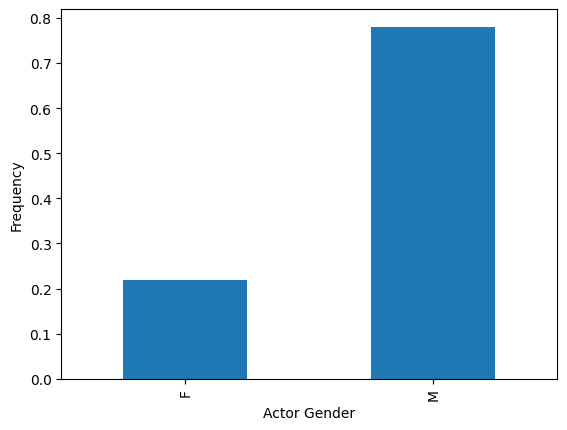

In [19]:
import matplotlib.pyplot as plt
df.groupby("gender")["memorable_quote"].count().div(df["memorable_quote"].count()
).plot.bar(xlabel="Actor Gender", ylabel = "Frequency")

We see that this dataset of memorable quotes is largely skewed male. This is good to keep in mind that our data will likely be biased in this way.

<Axes: xlabel='Actor Age', ylabel='Frequency'>

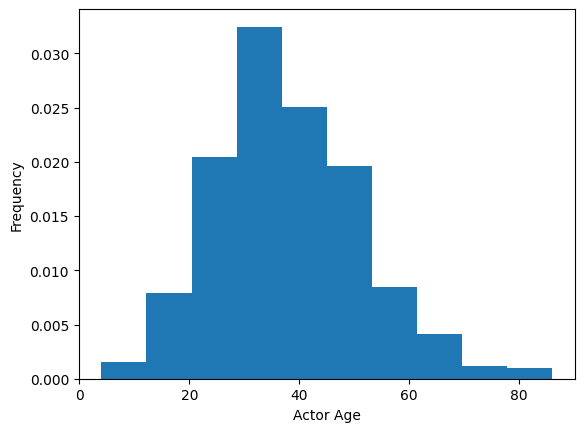

In [21]:
df["approx_age_filming"].plot.hist(xlabel = "Actor Age", ylabel = "Frequency", density=True)

We can see that our memorable quotes predominantly come from actors and actresses between 30-40

In [22]:
df_f = df[df["gender"] == "F"]
df_m = df[df["gender"] == "M"]

<Axes: ylabel='Frequency'>

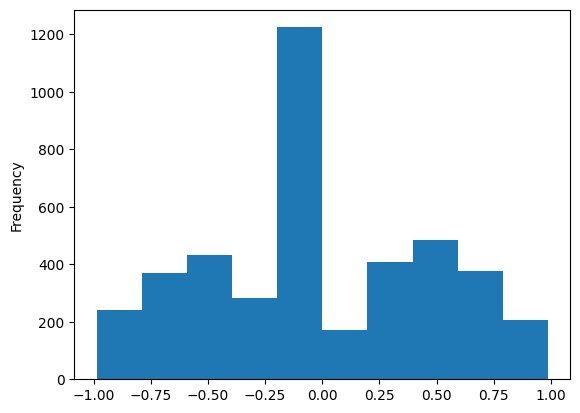

In [23]:
df["sentiment"].plot.hist()

Sentiments of memorable quotes from all genders and ages tend to be generally neutral, if not slightly negative.

In [24]:
import seaborn as sns

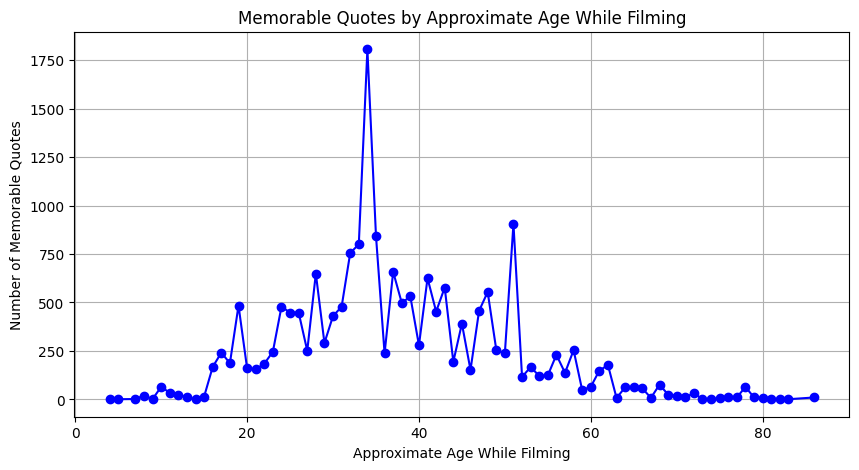

In [25]:
import matplotlib.pyplot as plt

# Aggregate the number of quotes by approx_age_filming
age_quote_counts = df.groupby("approx_age_filming")["quote_count"].sum()

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(age_quote_counts.index, age_quote_counts.values, marker='o',
         linestyle='-', color='b')
plt.xlabel("Approximate Age While Filming")
plt.ylabel("Number of Memorable Quotes")
plt.title("Memorable Quotes by Approximate Age While Filming")
plt.grid(True)

# Show the plot
plt.show()

<Axes: ylabel='Frequency'>

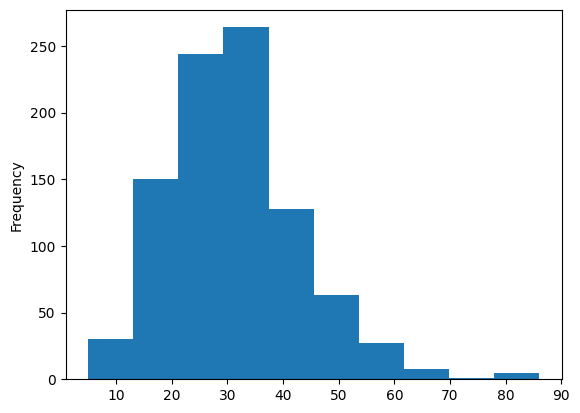

In [26]:
df_f["approx_age_filming"].plot.hist()

<Axes: ylabel='Frequency'>

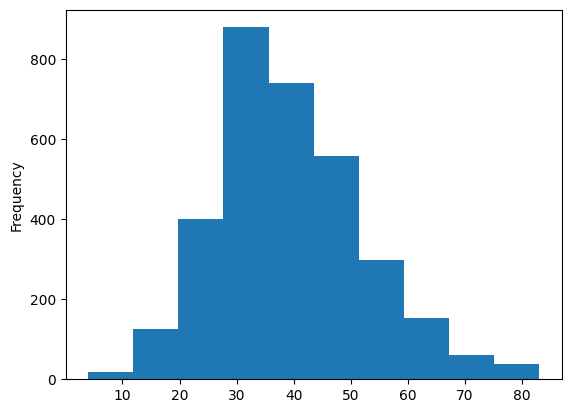

In [27]:
df_m["approx_age_filming"].plot.hist()

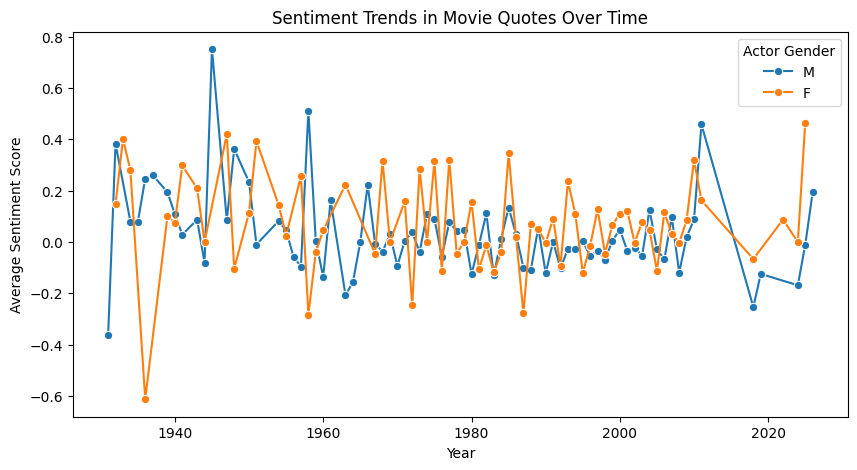

In [28]:
df_grouped = df.groupby(['release_year', 'gender'])['sentiment'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_grouped, x='release_year', y='sentiment', hue='gender', marker='o')

plt.title("Sentiment Trends in Movie Quotes Over Time")
plt.xlabel("Year")
plt.ylabel("Average Sentiment Score")
plt.legend(title="Actor Gender")
plt.show()

We see that there are not very strong trends in sentiment of memorable movie quotes over time between genders.

<ipython-input-30-ae5a97d6b365>:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(values='sentiment', index='gender', columns='decade', aggfunc=np.mean)
<ipython-input-30-ae5a97d6b365>:2: FutureWarning: The provided callable <function mean at 0x7f76357c53a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  heatmap_data = df.pivot_table(values='sentiment', index='gender', columns='decade', aggfunc=np.mean)


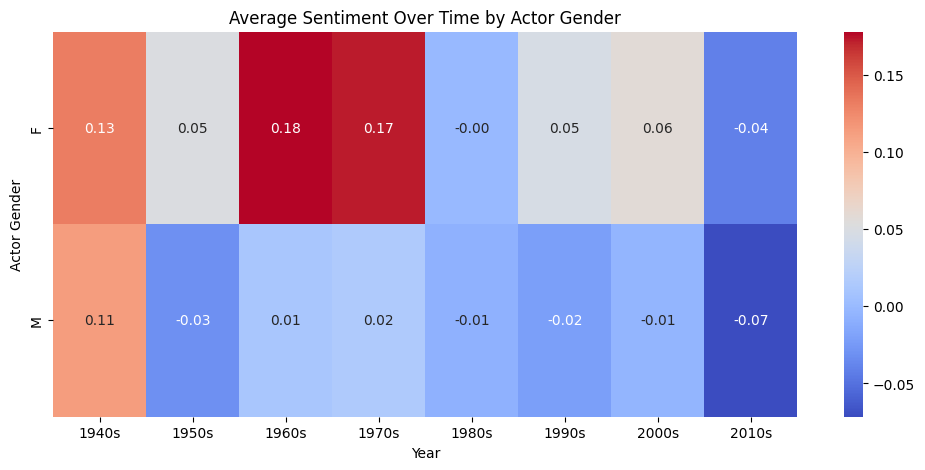

In [30]:
import numpy as np
heatmap_data = df.pivot_table(values='sentiment', index='gender',
                              columns='decade', aggfunc=np.mean)

plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f")

plt.title("Average Sentiment Over Time by Actor Gender")
plt.xlabel("Year")
plt.ylabel("Actor Gender")
plt.show()

We see that there is a slight decrease of sentiment across time by all genders. It seems that actresses had memorable quotes which were slightly more positive in the past than in the present.

<ipython-input-31-6feb24f09683>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(values='sentiment', index='age_group', columns='decade', aggfunc=np.mean)
<ipython-input-31-6feb24f09683>:1: FutureWarning: The provided callable <function mean at 0x7f76357c53a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  heatmap_data = df.pivot_table(values='sentiment', index='age_group', columns='decade', aggfunc=np.mean)


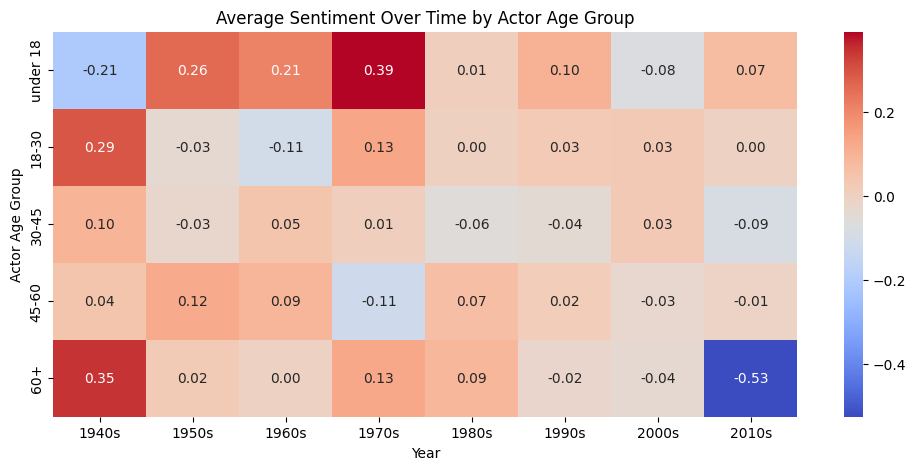

In [31]:
heatmap_data = df.pivot_table(values='sentiment', index='age_group',
                              columns='decade', aggfunc=np.mean)

plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f")

plt.title("Average Sentiment Over Time by Actor Age Group")
plt.xlabel("Year")
plt.ylabel("Actor Age Group")
plt.show()

Here we see very interesting variation between age groups. Actors and actresses under the age of 18 and at or above the age of 60 exhibited a wide variation in changes of sentiment in their memorable quotes. Actors and actresses in the middle ages were relatively consistent with a slight decrease over time. The variability is likely due to the fact that there is a lot more data for the middle age groups than the older and younger groups.

**Word Clouds**

Word Clouds are a nice way to visualize common occurences of words. We will be analyzing based on release year of movie and gender. The three datasets which were the most interesting were actresses-1960s, actresses-2010s, actors-2010s.

In [32]:
df_1960_f = df_f[(df_f["decade"] == "1960s")]
df_2010_f = df_f[(df_f["decade"] == "2010s")]
df_2010_m = df_m[(df_m["decade"] == "2010s")]

We will first process our quotes breaking down words into their base forms, turning all letters lowercase, tokenizing, and removing stopwords. We will then count word frequencies and display them using word clouds.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
<ipython-input-33-9cfc9f976739>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["processed_words"] = df["reviewText"].dropna().apply(preprocess_text)


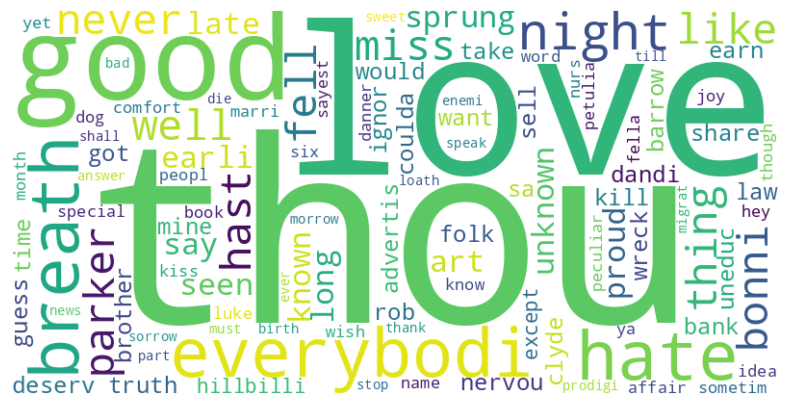

In [33]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Ensure necessary NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

df = df_1960_f

stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    words = word_tokenize(text.lower())
    words = [stemmer.stem(word) for word in words if word.isalpha() and
             word not in stop_words]  # Stem and filter
    return words

df["processed_words"] = df["reviewText"].dropna().apply(preprocess_text)

all_stems = [word for words in df["processed_words"] for word in words]

word_counts = Counter(all_stems)


wordcloud = WordCloud(width=800, height=400, background_color="white"
).generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Actresses from the 1960s definitely had very positive things to say, or at least that is what they are most remembered for. I find it funny that thou isn't a traditional stopword so it was kept in while being popular enough to make the list. Words like "love" and "good" definitely seem to imply good sentiment although "hate" is still decently prominent.

<ipython-input-34-7540277b817c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["processed_words"] = df["reviewText"].dropna().apply(preprocess_text)


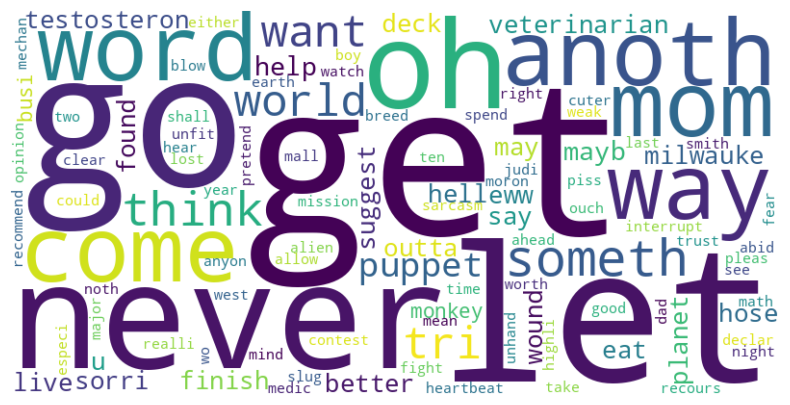

In [34]:
df = df_2010_f

stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    words = word_tokenize(text.lower())
    words = [stemmer.stem(word) for word in words if word.isalpha() and
             word not in stop_words]  # Stem and filter
    return words

df["processed_words"] = df["reviewText"].dropna().apply(preprocess_text)

all_stems = [word for words in df["processed_words"] for word in words]

word_counts = Counter(all_stems)


wordcloud = WordCloud(width=800, height=400, background_color="white"
).generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Actresses from the 2010s seem to express more neutral sentiment. Words like "go", "get", "let", and "oh" don't necessarily have a positive or negative sentiment but never seems to imply some negativity. It definitely seems like the most memorable quotes from actresses have slightly more negative sentiment than actresses from the 1960s. They also stopped saying "thou" which is kind of sad to me.

<ipython-input-35-a0e6076fc32c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["processed_words"] = df["reviewText"].dropna().apply(preprocess_text)


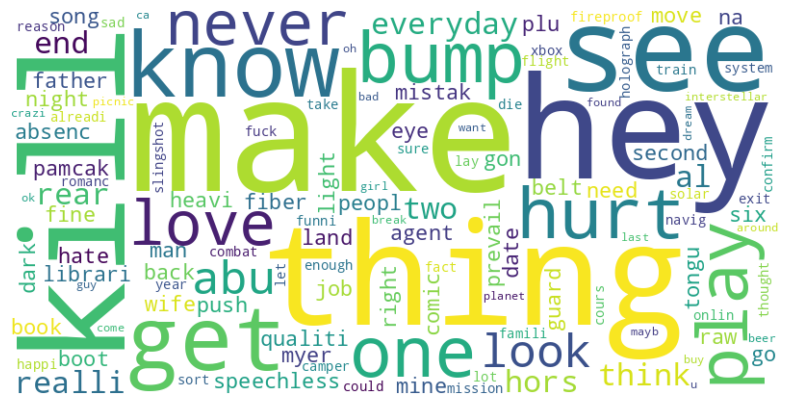

In [35]:
df = df_2010_m

stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    words = word_tokenize(text.lower())
    words = [stemmer.stem(word) for word in words if word.isalpha() and
             word not in stop_words]  # Stem and filter
    return words

df["processed_words"] = df["reviewText"].dropna().apply(preprocess_text)

all_stems = [word for words in df["processed_words"] for word in words]

word_counts = Counter(all_stems)


wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The most memorable quotes by males in the 2010s are interesting. That giant "kill" is pretty troubling and makes me wonder how what I remember from male characters in movies as a kid impacts how I am now. Nonetheless, this definitely different from the past two examples. The sentiment seems overall pretty neutral, but the word "hey" being popular in memorable quotes is interesting to me. It seems that we tend to remember male actors who are more forthcoming on screen although that could be a stretch.

Individual Profiles For Actors

Now let's look at some individual actors and actresses to see how the sentiments of their most memorable quotes have changed.

In [36]:
df_actors_m = pd.DataFrame(df_m["actor"].value_counts())
df_actors_m

,count
actor,
Johnny Depp,58
Brad Pitt,44
Tom Cruise,43
Tom Hanks,40
Robert De Niro,39
...,...
Shane West,1
Daniel Faraldo,1
James Arnold Taylor,1


In [37]:
depp = df_m[df_m["actor"] == "Johnny Depp"]
pitt = df_m[df_m["actor"] == "Brad Pitt"]
cruise = df_m[df_m["actor"] == "Tom Cruise"]

In [38]:
import plotly.express as px
import plotly.graph_objects as go

def plot_actor(name, df):
    df_avg = df.groupby(["movie_title", "approx_age_filming", "release_year"], as_index=False)["sentiment"].mean()
    df_avg = df_avg.sort_values(by="release_year")
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_avg["approx_age_filming"],
        y=df_avg["sentiment"],
        mode='lines',
        line=dict(color="black", width=2),
        name="Sentiment Trend"
    ))

    for movie in df_avg["movie_title"].unique():
        movie_data = df_avg[df_avg["movie_title"] == movie]
        fig.add_trace(go.Scatter(
            x=movie_data["approx_age_filming"],
            y=movie_data["sentiment"],
            mode='markers',
            marker=dict(size=10),
            name=movie,  # Legend shows movie-title-to-color mapping
        ))

    fig.update_layout(
        title=f"Quote Sentiment Evolution - {name}",
        xaxis_title="Actor's Age at Filming",
        yaxis_title="Avg. Quote Sentiment",
        width=800, height=500,
        showlegend=True
    )

    fig.show()


male_actors = {"Johnny Depp": depp, "Brad Pitt": pitt, "Tom Cruise": cruise}

for name, actor in male_actors.items():
    plot_actor(name, actor)


Clearly there is some variability between these actors and their most memorable lines although no clear pattern arises. Johnny Depp tends to stay closer to neutral and positive sentiment. Brad Pitt's first memorable movie quotes were very positive and then went to neutral and negative. Tom Cruise's sentiments of memorable are generally neutral to negative despite a peak during "Magnolia". The pattern seems largely correlated with the type of movie they were in.

In [39]:
df_actors_f = pd.DataFrame(df_f["actor"].value_counts())
df_actors_f
winslet = df_f[df_f["actor"] == "Kate Winslet"]
pfeiffer = df_f[df_f["actor"] == "Michelle Pfeiffer"]
davis = df_f[df_f["actor"] == "Geena Davis"]

female_actors = {"Kate Winslet": winslet, "Michelle Pfeiffer": pfeiffer, "Geena Davis": davis}

for name, actor in female_actors.items():
    plot_actor(name, actor)

Compared to the top 3 actors with the most memorable quotes, the top 3 actresses with the most memorable quotes had much more postive sentiments related to their memorable quotes.

**Attempts at Clustering**

We attempted to use KMeans Clustering to see if we could identify patterns of memorable quotes, but the results were inconclusive.


In [48]:
import pandas as pd

columns = ["movie_title", "memorable_quote", "LINE_ID_MEMORABLE_MATCHED_QUOTE"]
with open("/content/moviequotes.memorable_quotes.txt", "r", encoding="latin-1") as file:
    text = file.read()
chunks = text.strip().split("\n\n")
data = [chunk.split("\n") for chunk in chunks]

df_memorable = pd.DataFrame(data, columns = columns)

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

In [50]:
import numpy as np
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Load spaCy English model for lemmatization
nlp = spacy.load("en_core_web_sm")

# Sample movie quotes dataframe
#df_memorable = pd.DataFrame({"memorable_quote": ["I'll be back.", "May the Force be with you.", "You can't handle the truth!", "Here's Johnny!", "I see dead people."]})

# Function to preprocess text
def preprocess_text(text):
    doc = nlp(text.lower())  # Lowercase text
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])  # Lemmatization, remove stopwords & punctuation

# Apply preprocessing
df_memorable["processed_quote"] = df_memorable["memorable_quote"].apply(preprocess_text)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_memorable["processed_quote"])

# K-Means with Cosine Similarity
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10)
clusters = kmeans.fit_predict(X)

# Add cluster labels to DataFrame
df_memorable["cluster"] = clusters

# Display results
print(df_memorable[["memorable_quote", "cluster"]])

                                        memorable_quote  cluster
0                           Who knocked up your sister?        2
1     I was watching you out there, before. I've nev...        2
2     You're 18, you don't know what you want. And y...        3
3     Ooh, see that, there. Who needs affection when...        2
4     Just 'cause you're beautiful, that doesn't mea...        7
...                                                 ...      ...
6277  You're gonna' have a great time with her tonig...        1
6278  That's the thing about the truth. It'll set yo...        0
6279  Oh no! Come all this bloody way to get shot by...        2
6280  Well fought, Gentlemen. It's time to save the ...        8
6281  Excuse me, my Lord, there's something I must c...        2

[6282 rows x 2 columns]


In [51]:
# K-Means with Cosine Similarity
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=10)
clusters = kmeans.fit_predict(X)

# Add cluster labels to DataFrame
df_memorable["cluster"] = clusters

In [56]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_memorable["memorable_quote"])

n_clusters = 20
kmeans = KMeans(n_clusters = n_clusters)
cluster = kmeans.fit(X)
cluster

KMeans(n_clusters=20)

In [58]:
for doc in df_memorable["memorable_quote"][kmeans.labels_ == 8]:
  print(doc)
  print("-------")

What you got back home, little sister, to play your fuzzy warbles on? I bet you got little save pitiful, portable picnic players. Come with uncle and hear all proper! Hear angel trumpets and devil trombones. You are invited.
-------
Guys can have nightmares too ya know. Ya ain't got a corner on the market or somethin'.
-------
Schneider got wasted last night. He must have been working late. Some maniac sliced him up like a kielbasa, hacked him in the shower. Got bloody footprints all over the place.
-------
I've got sons, goddamn it! By God have I got sons!
-------
Hey, maybe you haven't been keeping up on current events, but we just got our asses kicked, pal!
-------
Maybe we got 'em demoralized.
-------
You got big. I mean, you aged. What I mean is in a good way you got big and older.
-------
Well, it's not right to go into details, I got nervous. I screwed up, I said the wrong thing... Where if I hadn't, I could be in bed right now with a woman who, if you make her laugh, you got a 

In [57]:
for doc in df_memorable["memorable_quote"][kmeans.labels_ == 0]:
  print(doc)
  print("--------")

I love America. No one is responsible for what they do.
--------
Oh, hah, I'm sorry, I keep forgetting. You were sick the day they taught law at law school.
--------
This person, they... they go in the front door, then they go out a window and down a rope in the middle of the night?  If I could do something like that, I'd be the star of my A.A.R.P. meetings.
--------
Warning. Assholes are closer than they appear.
--------
How the hell did they get Air Force One?
--------
Shanna, they bought their tickets, they knew what they were getting into. I say, let 'em crash.
--------
They tried to ruin me, but they are ruined. They tried to ruin me because they didn't like what I have done. Do you like what I've done?
--------
All non-denial denials. They doubt our ancestry, but they don't say the story isn't accurate.
--------
Can you believe these new girls? None of them use birth control and they eat all the steak!
--------
They're all so beautiful. Why don't I have three heads?
--------
My m

**Conclusion**

Our results show that memorable quotes are predominantly delivered by male and middle-aged actors and that sentiment overall has gone slightly negative over time. We also saw that female actors gave consistetly more postive quotes than male actors, and actors under 18 exhibit the greatest fluctuation in sentiment over time. Word frequency analysis highlights thematic difference between male and female actor's quotes. Our clustering also suggests that there are no universally dominant themes that define memorability. Quotes seem to be memorable largely due to their own merit rather the result of some formulaic construction or agenda being pushed which is something very comforting to me. It makes me appreciate the art even more.